# Gradient Boosting: CPU vs GPU
This is an example of gradient boosting on CPU and GPU on Google Colaboratory. We will get to see a speedup using a graphics processor on real small datasets even with s Tesla K80 (2014). This is to showcase the CatBoost gradient boosting library, which is known for it's good GPU performance with speed and strong precision out of the box.  
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github.com/erinkhoo/hard-skill-learning-list-2019/blob/master/Machine_Learning_Problems/CatBoost/CatBoost-small-dataset-cpu-vs-gpu.ipynb) 

## Set GPU as hardware accelerator
Be sure to select GPU as hardware accelerator.

* Navigate to `Runtime` menu and select `Change runtime type`
* Choose `GPU` as hardware accelerator
* Click `Save`

### Import CatBoost


In [16]:
!pip install catboost

In [0]:
# EDA
import numpy as np
import pandas as pd
import missingno
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# tools
import timeit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# algo
from catboost import CatBoostClassifier

## Download and prepare small dataset

In [19]:
# load Pima diabetes dataset
!wget https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/XGBoost/diabetes.csv

# dataframe
pima_dataset = pd.read_csv('diabetes.csv')

--2020-05-22 10:44:28--  https://raw.githubusercontent.com/erinkhoo/hard-skill-learning-list-2019/master/Machine_Learning_Problems/XGBoost/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/plain]
Saving to: ‘diabetes.csv.1’

diabetes.csv.1      100%[===================>]  23.31K  --.-KB/s    in 0.01s   

2020-05-22 10:44:28 (1.79 MB/s) - ‘diabetes.csv.1’ saved [23873/23873]



In [6]:
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


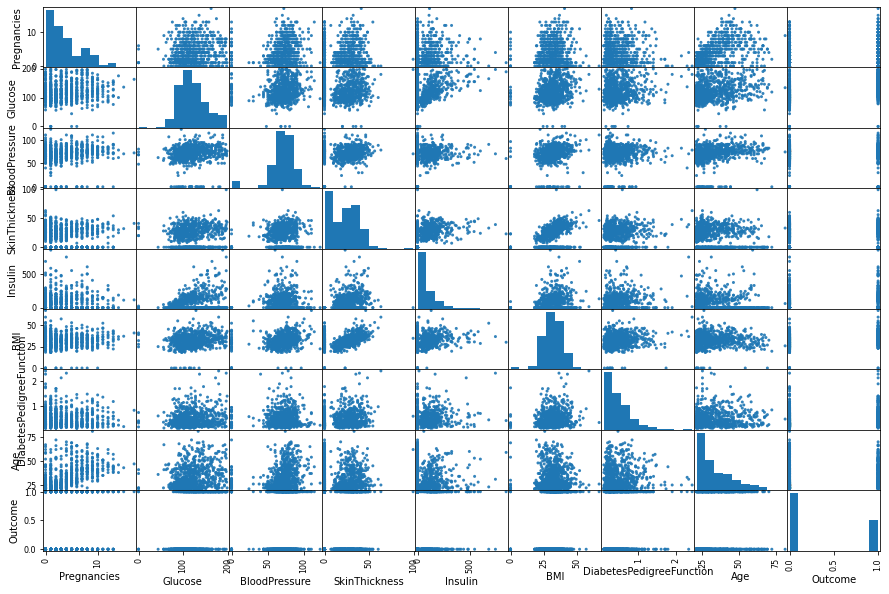

In [20]:
# scatterplot matrix on numerical features
scatter_matrix(pima_dataset, figsize=(15,10), alpha=.9, diagonal='hist')
plt.show()

In [0]:
# select X; features and y; target
X = pima_dataset.drop(['Outcome'], axis=1)
y = pima_dataset['Outcome']

# split data into train and text sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.25,
                                                    random_state=7)

## Training on CPU
Now we will train the model on CPU and measure execution time.
We will use 200 iterations for our CPU training.

In [0]:
# CPU Spec.
# Intel(R) Xeon(R) CPU @ 2.20GHz
!cat /proc/cpuinfo 

In [44]:
# CPU
def train_on_cpu():  
  model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03
  )
  
  model.fit(
      X_train, y_train,
      eval_set=(X_test, y_test),
      verbose=50
  );   
      
cpu_time = timeit.timeit('train_on_cpu()', 
                         setup="from __main__ import train_on_cpu", 
                         number=1)

print(f'Time to fit model on CPU: {int(cpu_time)} seconds')

0:	learn: 0.6761426	test: 0.6784867	best: 0.6784867 (0)	total: 4.27ms	remaining: 4.27s
50:	learn: 0.3968806	test: 0.4864851	best: 0.4864851 (50)	total: 88.1ms	remaining: 1.64s
100:	learn: 0.3223146	test: 0.4737983	best: 0.4737983 (100)	total: 164ms	remaining: 1.46s
150:	learn: 0.2791887	test: 0.4781436	best: 0.4737983 (100)	total: 259ms	remaining: 1.46s
200:	learn: 0.2416738	test: 0.4796258	best: 0.4737983 (100)	total: 345ms	remaining: 1.37s
250:	learn: 0.2091860	test: 0.4856704	best: 0.4737983 (100)	total: 423ms	remaining: 1.26s
300:	learn: 0.1826892	test: 0.4919829	best: 0.4737983 (100)	total: 504ms	remaining: 1.17s
350:	learn: 0.1581986	test: 0.4983245	best: 0.4737983 (100)	total: 584ms	remaining: 1.08s
400:	learn: 0.1348803	test: 0.5050016	best: 0.4737983 (100)	total: 664ms	remaining: 992ms
450:	learn: 0.1193269	test: 0.5086885	best: 0.4737983 (100)	total: 747ms	remaining: 909ms
500:	learn: 0.1030954	test: 0.5124470	best: 0.4737983 (100)	total: 829ms	remaining: 826ms
550:	learn: 0.

## Training on GPU
The previous code execution has been done on CPU. Now we are going to try this on a GPU. We need to use '*task_type='GPU'*' parameter value to run GPU training.

In [45]:
# GPU Spec.
!nvidia-smi

Fri May 22 11:17:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    57W / 149W |     78MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [50]:
# GPU
def train_on_gpu():  
  model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    task_type='GPU'
  )
  
  model.fit(
      X_train, y_train,
      eval_set=(X_test, y_test),
      verbose=50
  );     
      
gpu_time = timeit.timeit('train_on_gpu()', 
                         setup="from __main__ import train_on_gpu", 
                         number=1)

print(f'Time to fit model on GPU: {int(gpu_time)} seconds')
print(f'GPU speedup over CPU: {cpu_time/gpu_time:.5f}x')

0:	learn: 0.6768268	test: 0.6802487	best: 0.6802487 (0)	total: 49.7ms	remaining: 49.6s
50:	learn: 0.4115067	test: 0.4792118	best: 0.4792118 (50)	total: 2.16s	remaining: 40.2s
100:	learn: 0.3539516	test: 0.4652780	best: 0.4651905 (99)	total: 4.1s	remaining: 36.5s
150:	learn: 0.3192833	test: 0.4629500	best: 0.4626358 (148)	total: 6s	remaining: 33.8s
200:	learn: 0.2897875	test: 0.4662029	best: 0.4626358 (148)	total: 7.89s	remaining: 31.4s
250:	learn: 0.2655879	test: 0.4689325	best: 0.4626358 (148)	total: 9.86s	remaining: 29.4s
300:	learn: 0.2415344	test: 0.4716582	best: 0.4626358 (148)	total: 11.8s	remaining: 27.4s
350:	learn: 0.2233955	test: 0.4762992	best: 0.4626358 (148)	total: 13.8s	remaining: 25.5s
400:	learn: 0.2078226	test: 0.4853894	best: 0.4626358 (148)	total: 15.7s	remaining: 23.5s
450:	learn: 0.1908825	test: 0.4893638	best: 0.4626358 (148)	total: 17.7s	remaining: 21.6s
500:	learn: 0.1775294	test: 0.4951706	best: 0.4626358 (148)	total: 19.7s	remaining: 19.6s
550:	learn: 0.166901

As you can see GPU **slightly** faster than CPU on a small dataset (Pima; 789 rows, 8 features). Do bare in mind running this in Google Colab means 'CPU' is a `Intel Xeon @ 2.20GHz`; not a simple desktop CPU!

---

## Large dataset CPU vs. GPU
GPU training is useful for large datasets. Good speedup starts from 10k objects and the more objects you have, the more value you will get from GPU.

The example large dataset is [`epsilon`](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#epsilon), provided by Chih-Jen Lin. We can get this direct from the `catboost.datasets` module.




In [0]:
from catboost.datasets import epsilon

train, test = epsilon()

XX_train, yy_train = train.iloc[:,1:], train[0]
XX_test, yy_test = test.iloc[:,1:], test[0]

In [58]:
# take a peak at sample of the data
# first column is target lable/feature
print(f'{train.sample(3)}')
print(f'{test.sample(3)}')

        0         1         2     ...      1998      1999      2000
26835    1.0 -0.004800  0.017145  ...  0.005863  0.000490 -0.019023
385466  -1.0 -0.008717  0.023856  ... -0.025308 -0.015314 -0.033724
104504   1.0  0.031178  0.005633  ...  0.024106  0.039571  0.032733

[3 rows x 2001 columns]
       0         1         2     ...      1998      1999      2000
59785   1.0  0.003443  0.017343  ... -0.020408  0.031409  0.041718
12471  -1.0  0.028824 -0.018369  ...  0.039719  0.015603  0.024410
13721  -1.0 -0.013496  0.026050  ... -0.026001 -0.015128 -0.032958

[3 rows x 2001 columns]


In [59]:
# CPU
def train_on_cpu():  
  model = CatBoostClassifier(
    iterations=101,
    learning_rate=0.03
  )
  
  model.fit(
      XX_train, yy_train,
      eval_set=(XX_test, yy_test),
      verbose=10
  );   
      
cpu_time2 = timeit.timeit('train_on_cpu()', 
                         setup="from __main__ import train_on_cpu", 
                         number=1)

print(f'Time to fit model on CPU: {int(cpu_time2)} seconds')

0:	learn: 0.6877166	test: 0.6878169	best: 0.6878169 (0)	total: 5.78s	remaining: 9m 31s
10:	learn: 0.6457360	test: 0.6464643	best: 0.6464643 (10)	total: 59s	remaining: 7m 57s
20:	learn: 0.6168090	test: 0.6177230	best: 0.6177230 (20)	total: 1m 50s	remaining: 6m 53s
30:	learn: 0.5945243	test: 0.5956997	best: 0.5956997 (30)	total: 2m 39s	remaining: 5m 55s
40:	learn: 0.5763055	test: 0.5776250	best: 0.5776250 (40)	total: 3m 28s	remaining: 5m
50:	learn: 0.5611797	test: 0.5626152	best: 0.5626152 (50)	total: 4m 17s	remaining: 4m 7s
60:	learn: 0.5481624	test: 0.5497347	best: 0.5497347 (60)	total: 5m 6s	remaining: 3m 16s
70:	learn: 0.5368581	test: 0.5384530	best: 0.5384530 (70)	total: 5m 54s	remaining: 2m 24s
80:	learn: 0.5264803	test: 0.5280966	best: 0.5280966 (80)	total: 6m 40s	remaining: 1m 33s
90:	learn: 0.5173663	test: 0.5190608	best: 0.5190608 (90)	total: 7m 25s	remaining: 44.1s
99:	learn: 0.5095978	test: 0.5113519	best: 0.5113519 (99)	total: 8m 9s	remaining: 0us

bestTest = 0.5113519254
be

In [60]:
# GPU
def train_on_gpu():  
  model = CatBoostClassifier(
    iterations=101,
    learning_rate=0.03,
    task_type='GPU'
  )
  
  model.fit(
      XX_train, yy_train,
      eval_set=(XX_test, yy_test),
      verbose=10
  );     
      
gpu_time2 = timeit.timeit('train_on_gpu()', 
                         setup="from __main__ import train_on_gpu", 
                         number=1)

print(f'Time to fit model on GPU: {int(gpu_time2)} seconds')
print(f'GPU speedup over CPU: {cpu_time2/gpu_time2:.5f}x')

0:	learn: 0.6877711	test: 0.6878852	best: 0.6878852 (0)	total: 317ms	remaining: 31.3s
10:	learn: 0.6455921	test: 0.6462800	best: 0.6462800 (10)	total: 2.54s	remaining: 20.6s
20:	learn: 0.6167255	test: 0.6177958	best: 0.6177958 (20)	total: 4.6s	remaining: 17.3s
30:	learn: 0.5944954	test: 0.5958530	best: 0.5958530 (30)	total: 6.63s	remaining: 14.8s
40:	learn: 0.5759999	test: 0.5774570	best: 0.5774570 (40)	total: 8.64s	remaining: 12.4s
50:	learn: 0.5604664	test: 0.5621378	best: 0.5621378 (50)	total: 10.7s	remaining: 10.2s
60:	learn: 0.5473792	test: 0.5491125	best: 0.5491125 (60)	total: 12.6s	remaining: 8.08s
70:	learn: 0.5358309	test: 0.5376061	best: 0.5376061 (70)	total: 14.6s	remaining: 5.96s
80:	learn: 0.5256587	test: 0.5275507	best: 0.5275507 (80)	total: 16.6s	remaining: 3.89s
90:	learn: 0.5163469	test: 0.5182521	best: 0.5182521 (90)	total: 18.5s	remaining: 1.83s
99:	learn: 0.5087262	test: 0.5106391	best: 0.5106391 (99)	total: 20.2s	remaining: 0us
bestTest = 0.5106391406
bestIteration

As you can see GPU **much** faster than CPU on a large dataset (epsilon; 500,000 | 2000 features w/ 2 classes).

**Results**:
* GPU: 1.3 mins to fit; 30 seconds to learn
* CPU: 9.2 mins to fit; ~12 mins to learn
